## Mean Reversion

`Time series mean reversion` processes are widely observed in finance. As opposed to trend following, it assumes that the process has a tendency to revert to its average level over time. This average level is usually determined by physical or economical forces such as long term supply and demand. Prices might deviate from that long term mean due to sentimental or short-term disturbances on the market but eventually will revert back to its intrinsic value. 

A continuous mean-reverting time series can be represented by an `Ornstein-Uhlenbeck process` or Vasicek model in interest rate field, which is a special case of `Hull-White model` with constant volatility. It is also the continuous-time analogue of the discrete-time `AR(1) process`. To calibrate the OU process, there are generally two approaches based on formula (A9), i.e., the Least square and Maximum Likelihood Estimation. 

### Statistical Testing
we can be more confident that a profitable strategy is not just based on luck if it passes statistical tests.
### Augmented Dickey-Fuller Test
Augmented Dickey–Fuller test (ADF) detects if a time series contains unit root. Technically the name of unit root comes from the fact that the autoregressive polynomial has a root on the unit circle but basically it implies nonstationary.

## How to Test for Mean Reversion?

Four main statistical tools are commonly used:

### 1. Augmented Dickey-Fuller (ADF) Test
- Tests for **unit root** (random walk).
- **If p-value < 0.05**, we reject the null hypothesis ⇒ mean-reverting.

### 2. Hurst Exponent (H)
- Measures long-term memory of a time series.
  - H < 0.5 ⇒ Mean Reverting
  - H = 0.5 ⇒ Random Walk
  - H > 0.5 ⇒ Trending

### 3. Variance Ratio (VR) Test
- Compares variance over long horizons vs short horizons.
- VR ≈ 1 ⇒ random walk; VR < 1 ⇒ mean reversion.

### 4. Half-Life (Speed of Reversion)
- How long it takes for a series to revert halfway to the mean.

```python
HalfLife = -np.log(2) / np.log(beta)
```

## Mean Reversion Model: Ornstein–Uhlenbeck (OU) Process 

The OU process is a continuous-time stochastic process widely used to model mean-reverting time series. It is governed by the following stochastic differential equation:

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t
$$

- **$ X_t $**: the value of the process at time t  
- **$ \mu $**: long-term mean (the level it reverts to)  
- **$ \theta $**: speed of reversion (higher ⇒ faster reversion)  
- **$ \sigma $**: volatility (how much it fluctuates)  
- **$ dW_t $**: Wiener process (Brownian motion)

### Discrete-Time Approximation: AR(1)

Since most trading systems use discrete time (e.g. daily prices), we often use the AR(1) model as a discrete version of the OU process:

$$
x_t = \alpha + \beta x_{t-1} + \varepsilon_t
$$

- If $ \beta < 1 $, the process is mean-reverting.
- If $ \beta = 1 $, it's a random walk (non-stationary).
- If $ \beta > 1 $, it's explosive (rare in practice).

We can estimate $ \beta $ via linear regression of $ x_t $ on $ x_{t-1} $.

---

## Half-Life of Mean Reversion

The **half-life** measures how long it takes for a deviation from the mean to decay by 50%.

Using the AR(1) parameter $ \beta $, it is computed as:

$$
\text{HalfLife} = -\frac{\ln(2)}{\ln(\beta)}
$$

Interpretation:
- Shorter half-life ⇒ faster reversion
- Longer half-life ⇒ slower reversion, possibly trending

---

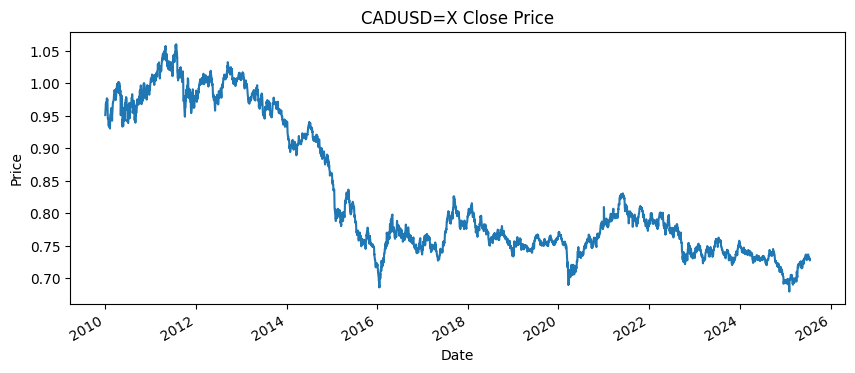

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (10, 4)


TICKER = "CADUSD=X"          
START  = "2010-01-01"        
END    = None                

fx_df = (
    yf.Ticker(TICKER)
      .history(start=START, end=END, auto_adjust=False)
      [["Close"]]
      .dropna()
      .tz_localize(None)     
)

series = fx_df["Close"]
series.name = TICKER

series.plot(title=f"{TICKER} Close Price")
plt.xlabel("Date"); plt.ylabel("Price"); plt.show()

In [11]:
# =========================
# 2. Augmented Dickey–Fuller (ADF) Test
# =========================
def adf_test(s: pd.Series, maxlag: int | None = 1) -> None:
    stat, p, lags, n, cv, *_ = adfuller(s, maxlag=maxlag, autolag="AIC")
    print("### Augmented Dickey–Fuller")
    print(f"ADF statistic : {stat:.4f}")
    print(f"p-value       : {p:.4f}")
    print(f"Lags used     : {lags}")
    print(f"Observations  : {n}")
    print("Critical vals :", {k: f"{v:.3f}" for k, v in cv.items()})

adf_test(series, maxlag=1)

### Augmented Dickey–Fuller
ADF statistic : -1.3275
p-value       : 0.6165
Lags used     : 1
Observations  : 4045
Critical vals : {'1%': '-3.432', '5%': '-2.862', '10%': '-2.567'}


In [7]:
# =========================
# 3. Hurst Exponent
# =========================
def hurst(ts, lags=range(2, 100)):
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return 2 * poly[0]

H = hurst(np.log(series.values))
print(f"### Hurst Exponent\nH = {H:.4f}  → {'Mean-reverting' if H<0.5 else 'Trending' if H>0.5 else 'Random Walk'}")

### Hurst Exponent
H = 0.4530  → Mean-reverting


In [18]:
# =========================
# 4. Half-Life Estimation
# =========================
def half_life(s: pd.Series):
    df = s.to_frame("price")
    df["lag"]  = df["price"].shift(1)
    df["diff"] = df["price"] - df["lag"]
    df.dropna(inplace=True)
    X = df["lag"].values.reshape(-1,1)
    y = df["diff"].values.reshape(-1,1)
    beta = LinearRegression().fit(X,y).coef_[0,0]
    return -np.log(2)/beta

hl = half_life(series)
print(f"### Half-Life\n≈ {hl:.1f} trading days")

### Half-Life
≈ 869.5 trading days
